In [1]:
import matplotlib
matplotlib.use('pdf')

%pylab inline
import seaborn; seaborn.set_style('whitegrid')
import pandas
import glob

from avocado import *

from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score
from sklearn.manifold import TSNE
from joblib import Parallel, delayed

from scipy.stats import spearmanr

lengths = chromosome_lengths

data_dir = '/net/noble/vol4/noble/user/jmschr/proj/avocado/data'
pred_dir = '/net/noble/vol5/user/jmschr/proj/avocado/predictions'

Populating the interactive namespace from numpy and matplotlib


In [2]:
def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2.0).mean()

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

# 1. Avocado Learns a Latent Representation of the Human Epigenome

## 1. Genomic Latent Representation vs Annotation

In [3]:
genome = numpy.load('../1_12_2018_Full_Model/genome_embedding_chr1.npy')

genome_embedding = genome[:,:25]
histone_embedding = genome[:,25:65][::10]
regulatory_embedding = genome[:,65:][::200]

In [4]:
celltype_embedding = numpy.load('../1_12_2018_Full_Model/celltype_embedding.npy')
assay_embedding = numpy.load('../1_12_2018_Full_Model/assay_embedding.npy')

### 1.1 Gencode Labels

In [5]:
data = pandas.read_csv("gencode.v19.annotation.protein_coding.full.bed", sep="\t", header=None, index_col=None, names=['chrom', 'start', 'end', 'gene', '?', '??'])

In [6]:
data['type'] = [d.split('-')[1] for d in data['gene']]

In [7]:
genome_labels = numpy.zeros(genome_embedding.shape[0]) - 1
histone_labels = numpy.zeros(histone_embedding.shape[0]) - 1
regulatory_labels = numpy.zeros(regulatory_embedding.shape[0]) - 1

label_mapping = {'first_cds': 0,
 'first_intron': 3,
 'last_cds': 2,
 'last_intron': 5,
 'middle_cds': 1,
 'middle_intron': 4,
 'promoter': 6,
 'utr_3prime': 7,
 'utr_5prime': 8}

label_mapping_2 = {'first_cds': 0,
 'first_intron': 1,
 'last_cds': 0,
 'last_intron': 1,
 'middle_cds': 0,
 'middle_intron': 1,
 'promoter': 2,
 'utr_3prime': 3,
 'utr_5prime': 3}

seen_labels = []

with open("gencode.v19.annotation.protein_coding.full.bed", "r") as infile:
    for line in infile:
        chrom, start, end, label, _, _ = line.split()
        label = label.split('-')[1]
        
        start = int(start)
        end = int(end)
        
        if chrom != 'chr1':
            continue
            
        genome_labels[start//25: end//25] = label_mapping_2[label]
        histone_labels[start//250:end//250] = label_mapping_2[label]
        regulatory_labels[start//5000:end//5000] = label_mapping_2[label]

In [8]:
X = []

embeddings = [genome_embedding, histone_embedding, regulatory_embedding]
labels = [genome_labels, histone_labels, regulatory_labels]

for label in range(-1, 4):
    x = []
    for embedding, l in zip(embeddings, labels):
        x.extend(embedding[l == label].mean(axis=0))
    
    X.append(x)

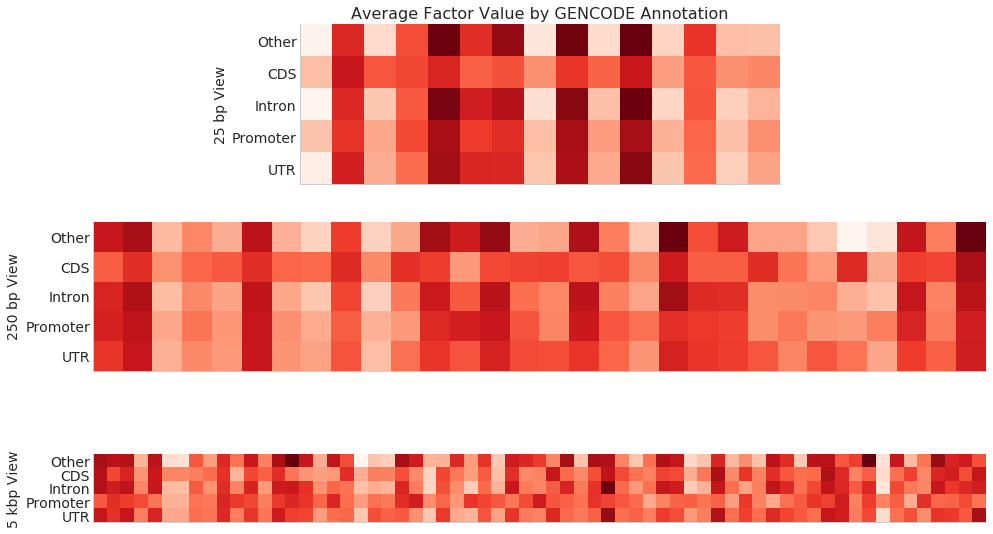

In [9]:
plt.figure(figsize=(16, 10), facecolor='w')

labels = ['Other', 'First CDS', 'Middle CDS', 'Last CDS', 'First Intron', 'Middle Intron', 'Last Intron',
         'Promoter', "UTR 3'", "UTR 5'"]

labels = ['Other', 'CDS', 'Intron', 'Promoter', 'UTR']

plt.subplot(311)
plt.title("Average Factor Value by GENCODE Annotation", fontsize=16)
plt.imshow(numpy.array(X)[:,:15], cmap='Reds', interpolation='nearest')
plt.yticks(range(5), labels, fontsize=14)
plt.ylabel("25 bp View", fontsize=14)
plt.xticks([], [])
plt.grid(False)
seaborn.despine()

plt.subplot(312)
plt.imshow(numpy.array(X)[:,15:45], cmap='Reds', interpolation='nearest')
plt.yticks(range(5), labels, fontsize=14)
plt.ylabel("250 bp View", fontsize=14)
plt.xticks([], [])
plt.grid(False)
seaborn.despine()

plt.subplot(313)
plt.imshow(numpy.array(X)[:,45:], cmap='Reds', interpolation='nearest')
plt.yticks(range(5), labels, fontsize=14)
plt.ylabel("5 kbp View", fontsize=14)
plt.xticks([], [])
plt.grid(False)
#plt.savefig("GENCODE.pdf")
seaborn.despine()

### 1.2 Assay Embeddings for Panel Selection

In [10]:
model = TSNE(n_components=2, random_state=0, perplexity=5, init='pca', learning_rate=.1, 
             early_exaggeration=1.0, verbose=2, method='exact')
y = model.fit_transform(assay_embedding)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 24 / 24
[t-SNE] Mean sigma: 0.308749
[t-SNE] Iteration 50: error = 0.5900747, gradient norm = 0.0581587 (50 iterations in 0.108s)
[t-SNE] Iteration 100: error = 0.3753149, gradient norm = 0.0233271 (50 iterations in 0.029s)
[t-SNE] Iteration 150: error = 0.3037329, gradient norm = 0.0121784 (50 iterations in 0.029s)
[t-SNE] Iteration 200: error = 0.2723016, gradient norm = 0.0073179 (50 iterations in 0.029s)
[t-SNE] Iteration 250: error = 0.2564265, gradient norm = 0.0048442 (50 iterations in 0.029s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 0.256426
[t-SNE] Iteration 300: error = 0.2536632, gradient norm = 0.0044325 (50 iterations in 0.029s)
[t-SNE] Iteration 350: error = 0.2476852, gradient norm = 0.0036337 (50 iterations in 0.029s)
[t-SNE] Iteration 400: error = 0.2410956, gradient norm = 0.0029039 (50 iterations in 0.031s)
[t-SNE] Iteration 450: error = 0.2352164,

In [11]:
top_assays = ['H3K4me3', 'H3K79me2', 'H3K9me3', 'H3K27me3', 'H3K36me3', 'H3K4me1']
top = map(assays.index, top_assays)
top = numpy.array(top)
mask = numpy.zeros(24, dtype=bool)
mask[top] = True
mask[7] = True

cmap = seaborn.color_palette('hls', 7)

plt.figure(figsize=(8, 6))
plt.title("PCA of Assay Embeddings", fontsize=16)

for i, (x1, x2) in enumerate(y):
    plt.text(assays[i], x1, x2, fontsize=12)

'''
plt.scatter(y[~mask, 0], y[~mask, 1], s=50, color='0.7')
plt.scatter(y[top[0], 0], y[top[0], 1], s=50, color=cmap[0], label=top_assays[0])
plt.scatter(y[top[1], 0], y[top[1], 1], s=50, color=cmap[1], label=top_assays[1])
plt.scatter(y[top[2], 0], y[top[2], 1], s=50, color=cmap[2], label=top_assays[2])
plt.scatter(y[top[3], 0], y[top[3], 1], s=50, color=cmap[3], label=top_assays[3])
plt.scatter(y[top[4], 0], y[top[4], 1], s=50, color=cmap[4], label=top_assays[4])
plt.scatter(y[top[5], 0], y[top[5], 1], s=50, color=cmap[5], label=top_assays[5])
plt.scatter(y[7, 0], y[7, 1], s=50, color=cmap[6], label="DNase")

plt.xlabel("Principle Component 1", fontsize=14)
plt.ylabel("Principle Component 2", fontsize=14)
plt.legend(fontsize=14)
'''

'\nplt.scatter(y[~mask, 0], y[~mask, 1], s=50, color=\'0.7\')\nplt.scatter(y[top[0], 0], y[top[0], 1], s=50, color=cmap[0], label=top_assays[0])\nplt.scatter(y[top[1], 0], y[top[1], 1], s=50, color=cmap[1], label=top_assays[1])\nplt.scatter(y[top[2], 0], y[top[2], 1], s=50, color=cmap[2], label=top_assays[2])\nplt.scatter(y[top[3], 0], y[top[3], 1], s=50, color=cmap[3], label=top_assays[3])\nplt.scatter(y[top[4], 0], y[top[4], 1], s=50, color=cmap[4], label=top_assays[4])\nplt.scatter(y[top[5], 0], y[top[5], 1], s=50, color=cmap[5], label=top_assays[5])\nplt.scatter(y[7, 0], y[7, 1], s=50, color=cmap[6], label="DNase")\n\nplt.xlabel("Principle Component 1", fontsize=14)\nplt.ylabel("Principle Component 2", fontsize=14)\nplt.legend(fontsize=14)\n'

Error in callback <function post_execute at 0x7f078e48f6e0> (for post_execute):


AttributeError: 'NoneType' object has no attribute 'seq'

AttributeError: 'NoneType' object has no attribute 'seq'

### 1.3. Cell Type Latent Space Forms Clusters

In [12]:
types = ['Other' for i in range(128)]

with open('RoadmapNames.txt', 'r') as infile:
    for line in infile:
        celltype, _, group = line.split()[:4]
        celltype = celltypes.index(celltype)
        types[celltype] = group

types = numpy.array(types)

for group, count in zip(*numpy.unique(types, return_counts=True)):
    if count < 5:
        types[types == group] = 'OTHER'
types[types == 'LUNG'] = 'OTHER'

type_set = numpy.unique(types)
func_types = type_set[type_set != 'OTHER']

In [13]:
model = TSNE(n_components=2, random_state=0, method='exact', verbose=2, learning_rate=0.1, early_exaggeration=1.0, n_iter=5000)
y = model.fit_transform(celltype_embedding)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 128 / 128
[t-SNE] Mean sigma: 0.610603
[t-SNE] Iteration 50: error = 1.3299789, gradient norm = 0.0000240 (50 iterations in 0.182s)
[t-SNE] Iteration 100: error = 1.3299772, gradient norm = 0.0002465 (50 iterations in 0.149s)
[t-SNE] Iteration 150: error = 1.3230574, gradient norm = 0.0155319 (50 iterations in 0.151s)
[t-SNE] Iteration 200: error = 0.9907363, gradient norm = 0.0296097 (50 iterations in 0.153s)
[t-SNE] Iteration 250: error = 0.7884408, gradient norm = 0.0156259 (50 iterations in 0.151s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 0.788441
[t-SNE] Iteration 300: error = 0.7615338, gradient norm = 0.0133840 (50 iterations in 0.150s)
[t-SNE] Iteration 350: error = 0.7113764, gradient norm = 0.0104533 (50 iterations in 0.152s)
[t-SNE] Iteration 400: error = 0.6583541, gradient norm = 0.0077558 (50 iterations in 0.153s)
[t-SNE] Iteration 450: error = 0.621778

[t-SNE] Iteration 4350: error = 0.5222041, gradient norm = 0.0000135 (50 iterations in 0.152s)
[t-SNE] Iteration 4400: error = 0.5222032, gradient norm = 0.0000128 (50 iterations in 0.150s)
[t-SNE] Iteration 4450: error = 0.5222025, gradient norm = 0.0000119 (50 iterations in 0.152s)
[t-SNE] Iteration 4500: error = 0.5222018, gradient norm = 0.0000109 (50 iterations in 0.151s)
[t-SNE] Iteration 4550: error = 0.5222012, gradient norm = 0.0000101 (50 iterations in 0.151s)
[t-SNE] Iteration 4600: error = 0.5222006, gradient norm = 0.0000094 (50 iterations in 0.151s)
[t-SNE] Iteration 4650: error = 0.5222001, gradient norm = 0.0000091 (50 iterations in 0.151s)
[t-SNE] Iteration 4700: error = 0.5221996, gradient norm = 0.0000097 (50 iterations in 0.150s)
[t-SNE] Iteration 4750: error = 0.5221988, gradient norm = 0.0000124 (50 iterations in 0.151s)
[t-SNE] Iteration 4800: error = 0.5221973, gradient norm = 0.0000214 (50 iterations in 0.150s)
[t-SNE] Iteration 4850: error = 0.5221923, gradien

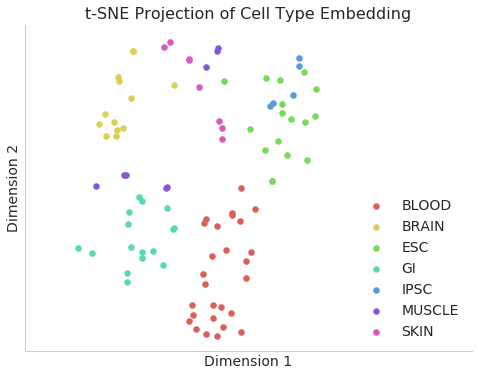

In [14]:
cmap = seaborn.color_palette("hls", 7)

plt.figure(figsize=(8, 6), facecolor='w' )
for i, label in enumerate(func_types):
    plt.scatter(y[types == label, 0], y[types == label, 1], color=cmap[i], s=30, label=label)

#idx = map(celltypes.index, ['E081', 'E082', 'E070']) # Fetal Brain + Matrix
#idx = map(celltypes.index, ['E093', 'E112'])
#idx = map(celltypes.index, ['E127', 'E057', 'E058']) # Keratinocytes
#idx = map(celltypes.index, ['E114', 'E117']) # HeLa-S3 and A549 cervical carcinoma


#plt.scatter([y[idx, 0]], [y[idx, 1]], color='k')
    
plt.title("t-SNE Projection of Cell Type Embedding", fontsize=16)
plt.xlabel("Dimension 1", fontsize=14)
plt.ylabel("Dimension 2", fontsize=14)
plt.xticks([], [])
plt.yticks([], [])
plt.xlim(-15, 25)
plt.legend(fontsize=14, loc=4)
seaborn.despine()
plt.savefig('Avocado-Supplement_celltypes.pdf')
plt.show()

# 2. Comparison to ChromImpute

## 2.1: TSS H3K4me3 Signal

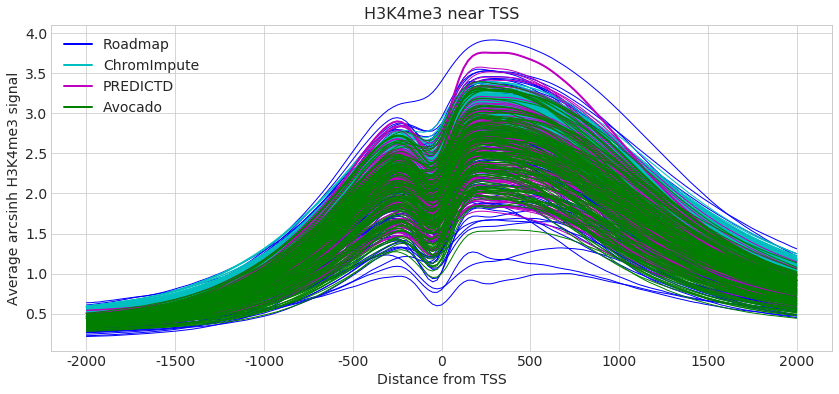

In [15]:
avg_signal = numpy.load("tss.npy")

plt.figure(figsize=(14, 6), facecolor='w')
plt.title("H3K4me3 near TSS", fontsize=16)
plt.plot(avg_signal[0].T, color='b', linewidth=1)
plt.plot(avg_signal[0, 0, :], color='b', linewidth=2, label="Roadmap")
plt.plot(avg_signal[1].T, color='c', linewidth=1)
plt.plot(avg_signal[1, 0, :], color='c', linewidth=2, label="ChromImpute")
plt.plot(avg_signal[2].T, color='m', linewidth=1)
plt.plot(avg_signal[2, 0, :], color='m', linewidth=2, label="PREDICTD")
plt.plot(avg_signal[3].T, color='g', linewidth=1)
plt.plot(avg_signal[3, 0, :], color='g', linewidth=2, label="Avocado")

plt.xlabel("Distance from TSS", fontsize=14)
plt.ylabel("Average arcsinh H3K4me3 signal", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(numpy.arange(0, 161, 20), numpy.arange(-2000, 2001, 500), fontsize=14)
plt.legend(fontsize=14, loc=2)
plt.show()

[1.         0.42300572 0.62544526 0.67066226]


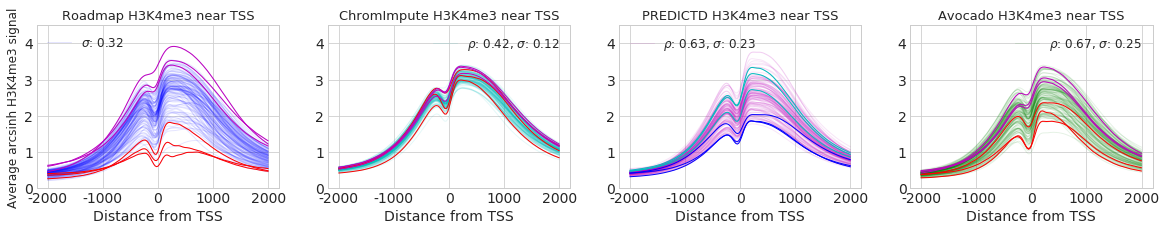

In [16]:
plt.figure(figsize=(20, 3), facecolor='w')
rho = numpy.corrcoef(avg_signal.sum(axis=2))[0]
rho = spearmanr(avg_signal.sum(axis=2).T)[0][0]
print rho
sigma = avg_signal.std(axis=1).mean(axis=1)

plt.subplot(141)
plt.title("Roadmap H3K4me3 near TSS", fontsize=13)
plt.plot(avg_signal[0].T, color='b', linewidth=1, alpha=0.1)
plt.plot(avg_signal[0, 0].T, color='b', linewidth=1, alpha=0.1, label=r"$\sigma$: {:2.2}".format(sigma[0]))
plt.plot(avg_signal[0, [78, 62, 1], :].T, color='r', linewidth=1)
plt.plot(avg_signal[0, [54, 57, 55], :].T, color='m', linewidth=1)
plt.ylabel("Average arcsinh H3K4me3 signal", fontsize=12)
plt.xlabel("Distance from TSS", fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.xticks(numpy.arange(0, 161, 40), numpy.arange(-2000, 2001, 1000), fontsize=14)
plt.ylim(0, 4.5)

plt.subplot(142)
plt.title("ChromImpute H3K4me3 near TSS", fontsize=13)
plt.plot(avg_signal[1].T, color='c', linewidth=1, alpha=0.1)
plt.plot(avg_signal[1, 0], color='c', linewidth=1, alpha=0.1, label=r"$\rho$: {:2.2}, $\sigma$: {:2.2}".format(rho[1], sigma[1]))
plt.plot(avg_signal[1, [78, 62, 1], :].T, color='r', linewidth=1)
plt.plot(avg_signal[1, [54, 57, 55], :].T, color='m', linewidth=1)
plt.xlabel("Distance from TSS", fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.xticks(numpy.arange(0, 161, 40), numpy.arange(-2000, 2001, 1000), fontsize=14)
plt.ylim(0, 4.5)

plt.subplot(143)
plt.title("PREDICTD H3K4me3 near TSS", fontsize=13)
plt.plot(avg_signal[2].T, color='m', linewidth=1, alpha=0.1)
plt.plot(avg_signal[2, 0], color='m', linewidth=1, alpha=0.1, label=r"$\rho$: {:2.2}, $\sigma$: {:2.2}".format(rho[2], sigma[2]))
plt.plot(avg_signal[2, [78, 62, 1], :].T, color='b', linewidth=1)
plt.plot(avg_signal[2, [54, 57, 55], :].T, color='c', linewidth=1)
plt.xlabel("Distance from TSS", fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.xticks(numpy.arange(0, 161, 40), numpy.arange(-2000, 2001, 1000), fontsize=14)
plt.ylim(0, 4.5)

plt.subplot(144)
plt.title("Avocado H3K4me3 near TSS", fontsize=13)
plt.plot(avg_signal[3].T, color='g', linewidth=1, alpha=0.1)
plt.plot(avg_signal[3, 0], color='g', linewidth=1, alpha=0.1, label=r"$\rho$: {:2.2}, $\sigma$: {:2.2}".format(rho[3], sigma[3]))
plt.plot(avg_signal[3, [78, 62, 1], :].T, color='r', linewidth=1)
plt.plot(avg_signal[3, [54, 57, 55], :].T, color='m', linewidth=1)
plt.xlabel("Distance from TSS", fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.xticks(numpy.arange(0, 161, 40), numpy.arange(-2000, 2001, 1000), fontsize=14)
plt.ylim(0, 4.5)

#plt.savefig("tss.pdf")
plt.show()

In [17]:
avg_signal.sum(axis=(1, 2))

array([30346.01476946, 36289.10137646, 29334.09359044, 28626.06870403])

## 2.2: Promoter Recovery (PromRecov)

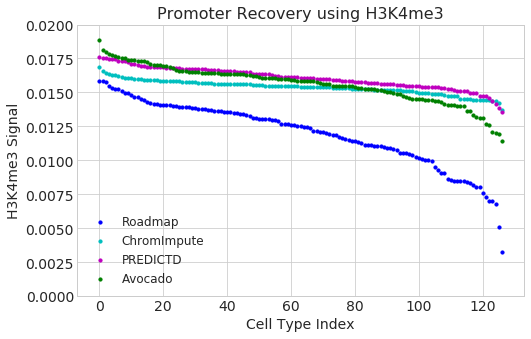

In [18]:
promrecov = numpy.load("promrecov.npy")
idx1 = promrecov[:,0].argsort()[::-1]
idx2 = promrecov[:,1].argsort()[::-1]
idx3 = promrecov[:,2].argsort()[::-1]
idx4 = promrecov[:,3].argsort()[::-1]
n = len(promrecov)

plt.figure(figsize=(8, 5), facecolor='w')
plt.title("Promoter Recovery using H3K4me3", fontsize=16)
plt.scatter(range(n), promrecov[idx1, 0], s=10, color='b', label="Roadmap")
plt.scatter(range(n), promrecov[idx2, 1], s=10, color='c', label="ChromImpute")
plt.scatter(range(n), promrecov[idx3, 2], s=10, color='m', label="PREDICTD")
plt.scatter(range(n), promrecov[idx4, 3], s=10, color='g', label="Avocado")
plt.xlabel("Cell Type Index", fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("H3K4me3 Signal", fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 0.02)
plt.legend(fontsize=12)
plt.show()

In [19]:
(promrecov[:, 3] > promrecov[:, 2]).sum()

40

## 2.3: Gene Body H3K36me3 Signal

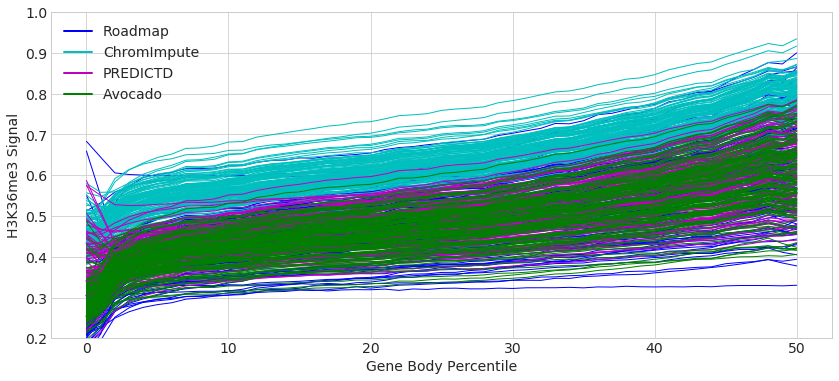

In [20]:
avg_signal = numpy.load("genebody.npy")

plt.figure(figsize=(14, 6), facecolor='w')
plt.plot(avg_signal[0].T, color='b', linewidth=1)
plt.plot(avg_signal[0, 0, :], color='b', linewidth=2, label="Roadmap")
plt.plot(avg_signal[1].T, color='c', linewidth=1)
plt.plot(avg_signal[1, 0, :], color='c', linewidth=2, label="ChromImpute")
plt.plot(avg_signal[2].T, color='m', linewidth=1)
plt.plot(avg_signal[2, 0, :], color='m', linewidth=2, label="PREDICTD")
plt.plot(avg_signal[3].T, color='g', linewidth=1)
plt.plot(avg_signal[3, 0, :], color='g', linewidth=2, label="Avocado")

plt.xlabel("Gene Body Percentile", fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("H3K36me3 Signal", fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0.2, 1.0)
plt.show()

In [21]:
avg_signal[:,:50].std(axis=1).mean(axis=1)

array([0.07975717, 0.03805895, 0.05483138, 0.05119571])

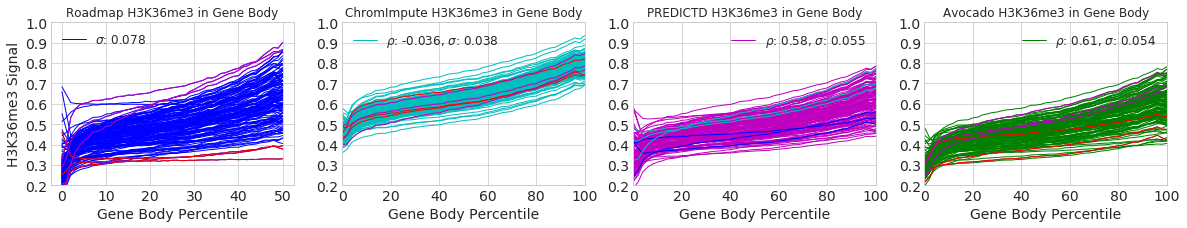

In [22]:
rho = spearmanr(avg_signal[:,:,:50].sum(axis=2).T)[0][0]
sigma = avg_signal.std(axis=1).mean(axis=1)

plt.figure(figsize=(20, 3), facecolor='w')
plt.subplot(141)
plt.title("Roadmap H3K36me3 in Gene Body", fontsize=12)
plt.plot(avg_signal[0].T, color='b', linewidth=1)
plt.plot(avg_signal[0, 0].T, color='b', linewidth=1, label=r"$\sigma$: {:2.2}".format(sigma[0]))
plt.plot(avg_signal[0, [3,  97,  21], :].T, color='r', linewidth=1)
plt.plot(avg_signal[0, [121,  26,  12], :].T, color='m', linewidth=1)
plt.ylabel("H3K36me3 Signal", fontsize=14)
plt.xlabel("Gene Body Percentile", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.2, 1.0)

plt.subplot(142)
plt.title("ChromImpute H3K36me3 in Gene Body", fontsize=12)
plt.plot(avg_signal[1].T, color='c', linewidth=1)
plt.plot(avg_signal[1, 0], color='c', linewidth=1, label=r"$\rho$: {:2.2}, $\sigma$: {:2.2}".format(rho[1], sigma[1]))
plt.plot(avg_signal[1, [3,  97,  21], :].T, color='r', linewidth=1)
plt.plot(avg_signal[1, [121,  26,  12], :].T, color='m', linewidth=1)
plt.xlabel("Gene Body Percentile", fontsize=14)
plt.xticks(range(0, 51, 10), range(0, 101, 20), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.ylim(0.2, 1.0)
plt.xlim(0, 50)

plt.subplot(143)
plt.title("PREDICTD H3K36me3 in Gene Body", fontsize=12)
plt.plot(avg_signal[2].T, color='m', linewidth=1)
plt.plot(avg_signal[2, 0], color='m', linewidth=1, label=r"$\rho$: {:2.2}, $\sigma$: {:2.2}".format(rho[2], sigma[2]))
plt.plot(avg_signal[2, [3,  97,  21], :].T, color='b', linewidth=1)
plt.plot(avg_signal[2, [121,  26,  12], :].T, color='c', linewidth=1)
plt.xlabel("Gene Body Percentile", fontsize=14)
plt.xticks(range(0, 51, 10), range(0, 101, 20), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.ylim(0.2, 1.0)
plt.xlim(0, 50)

plt.subplot(144)
plt.title("Avocado H3K36me3 in Gene Body", fontsize=12)
plt.plot(avg_signal[3].T, color='g', linewidth=1)
plt.plot(avg_signal[3, 0], color='g', linewidth=1, label=r"$\rho$: {:2.2}, $\sigma$: {:2.2}".format(rho[3], sigma[3]))
plt.plot(avg_signal[3, [3,  97,  21], :].T, color='r', linewidth=1)
plt.plot(avg_signal[3, [121,  26,  12], :].T, color='m', linewidth=1)
plt.xlabel("Gene Body Percentile", fontsize=14)
plt.xticks(range(0, 51, 10), range(0, 101, 20), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.ylim(0.2, 1.0)
plt.xlim(0, 50)
#plt.savefig("genebody.pdf")
plt.show()

## 2.4: Gene Recovery (GeneRecov)

In [23]:
generecov = numpy.load("generecov.npy")
idx1 = numpy.argsort(generecov[:,0])[::-1]
idx2 = numpy.argsort(generecov[:,1])[::-1]
idx3 = numpy.argsort(generecov[:,2])[::-1]
idx4 = numpy.argsort(generecov[:,3])[::-1]
n = len(generecov)

plt.figure(figsize=(8, 5), facecolor='w')
plt.scatter(range(n), generecov[:,0][idx1], s=10, color='b', label="Experimental")
plt.scatter(range(n), generecov[:,1][idx2], s=10, color='c', label="ChromImpute")
plt.scatter(range(n), generecov[:,2][idx3], s=10, color='m', label="PREDICTD")
plt.scatter(range(n), generecov[:,3][idx4], s=10, color='g', label="Avocado")
plt.xlabel("Cell Type Index", fontsize=14)
plt.ylabel("AUROC 5%", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 0.01)
plt.legend(fontsize=12)
plt.title("Gene Recovery using H3K36me3", fontsize=16)

IOError: [Errno 2] No such file or directory: 'generecov.npy'

## 2.7: Correlations Across Tracks

In [ ]:
labels = []
with open('RoadmapNames.txt', 'r') as infile:
    for line in infile:
        celltype, _, label = line.strip('\n').split()
        labels.append(label)

In [ ]:
assays = 'H3K4me1', 'H3K4me3', 'H3K36me3', 'H3K27me3', 'H3K9me3', 'H3K27ac', 'H3K9ac', 'DNase'

In [ ]:
y_true = numpy.zeros((len(celltypes), len(celltypes)))
for i, label_x in enumerate(labels):
    for j, label_y in enumerate(labels):
        if label_x == label_y:
            y_true[i, j] = 1

In [ ]:
assays = 'H3K4me1', 'H3K4me3', 'H3K36me3', 'H3K27me3', 'H3K9me3', 'H3K27ac', 'H3K9ac', 'DNase'

roadmap_aurocs = []
chromimpute_aurocs = []
predictd_aurocs = []
avocado_aurocs = []

for assay in assays:
    corr = numpy.load('{}_roadmap_correlations.npy'.format(assay))
    corr = numpy.tril(corr, -1).ravel()
    
    y_t = numpy.tril(y_true, -1).ravel()[corr != 0]
    corr = corr[corr != 0]
    
    roadmap_auroc = roc_auc_score(y_t, corr)
    
    corr = numpy.load('{}_chromimpute_correlations.npy'.format(assay))
    corr = numpy.tril(corr, -1).ravel()
    y_t = numpy.tril(y_true, -1).ravel()[corr != 0]
    corr = corr[corr != 0]
    
    chromimpute_auroc = roc_auc_score(y_t, corr)

    corr = numpy.load('{}_predictd_correlations.npy'.format(assay))
    corr = numpy.tril(corr, -1).ravel()
    y_t = numpy.tril(y_true, -1).ravel()[corr != 0]
    corr = corr[corr != 0]
    
    predictd_auroc = roc_auc_score(y_t, corr)
    
    corr = numpy.load('{}_avocado_correlations.npy'.format(assay))
    corr = numpy.tril(corr, -1).ravel()
    y_t = numpy.tril(y_true, -1).ravel()[corr != 0]
    corr = corr[corr != 0]
    
    avocado_auroc = roc_auc_score(y_t, corr)
    
    roadmap_aurocs.append(roadmap_auroc)
    chromimpute_aurocs.append(chromimpute_auroc)
    predictd_aurocs.append(predictd_auroc)
    avocado_aurocs.append(avocado_auroc)

In [ ]:
n = len(celltype_embedding)
corr = celltype_embedding[:-1].dot(celltype_embedding[:-1].T)
        
corr = numpy.tril(corr, -1).ravel()
y_t = numpy.tril(y_true, -1).ravel()

embedding_corr = roc_auc_score(y_t, corr)

plt.figure(figsize=(15, 4), facecolor='w')
plt.title("Roadmap Grouping Classification via Correlation", fontsize=16)
plt.bar(numpy.arange(8), roadmap_aurocs, width=0.19, color='b', edgecolor='b', label="Roadmap")
plt.bar(numpy.arange(8)+0.2, chromimpute_aurocs, width=0.19, color='c', edgecolor='c', label="ChromImpute")
plt.bar(numpy.arange(8)+0.4, predictd_aurocs, width=0.19, color='m', edgecolor='m', label="PREDICTD")
plt.bar(numpy.arange(8)+0.6, avocado_aurocs, width=0.19, color='g', edgecolor='g', label="Avocado")

plt.plot([-0.2, 8], [embedding_corr, embedding_corr], c='r', linewidth=2, label="Latent Factors")

plt.xlabel("Assay", fontsize=16)
plt.ylabel("AUROC", fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(numpy.arange(8)+0.4, assays, fontsize=14)
plt.legend(fontsize=14)

seaborn.despine()
plt.ylim(0, 1)
plt.xlim(-0.2, 10)
plt.savefig('Avocado-Supplement_correlations.pdf')
plt.show()

## 2.8 Epigenomic Marks

In [29]:
def plot_errors(x11, x12, x21, x22, x31, x32, x41, x42, xlabel, ylabel, xlim, ylim, hist_xlim):
    corr_1 = numpy.corrcoef([x11, x12])[0, 1]
    corr_2 = numpy.corrcoef([x21, x22])[0, 1]
    corr_3 = numpy.corrcoef([x31, x32])[0, 1]
    corr_4 = numpy.corrcoef([x41, x42])[0, 1]
    
    plt.figure(figsize=(18, 3), facecolor='w')
    plt.subplot(151)
    plt.title("Roadmap", fontsize=14)
    #plt.scatter(x11[::20], x12[::20], color='b', s=1, label=r"$\rho$: {:4.4}".format(corr_1))
    seaborn.kdeplot(x11[::1000], x12[::1000], shade=False, n_levels=100, label=r"$\rho$: {:4.4}".format(corr_1))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.xticks(fontsize=12)
    plt.legend(fontsize=12)

    plt.subplot(152)
    plt.title("ChromImpute", fontsize=14)
    #plt.scatter(x21[::100], x22[::100], color='c', s=1, label=r"$\rho$: {:4.4}".format(corr_2))
    seaborn.kdeplot(x21[::1000], x22[::1000], shade=False, n_levels=100, label=r"$\rho$: {:4.4}".format(corr_2))
    plt.xlabel(xlabel, fontsize=12)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.legend(fontsize=12)

    plt.subplot(153)
    plt.title("PREDICTD", fontsize=14)
    #plt.scatter(x31[::100], x32[::100], color='m', s=1, label=r"$\rho$: {:4.4}".format(corr_3))
    seaborn.kdeplot(x31[::1000], x32[::1000], shade=False, n_levels=100, label=r"$\rho$: {:4.4}".format(corr_3))
    plt.xlabel(xlabel, fontsize=12)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.legend(fontsize=12)

    plt.subplot(154)
    plt.title("Avocado", fontsize=14)
    #plt.scatter(x41[::100], x42[::100], color='g', s=1, label=r"$\rho$: {:4.4}".format(corr_4))
    seaborn.kdeplot(x41[::1000], x42[::1000], shade=False, n_levels=100, label=r"$\rho$: {:4.4}".format(corr_4))
    plt.xlabel(xlabel, fontsize=12)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.legend(fontsize=12)

    def hist(x, color, label):
        plt.hist(x, color=color, bins=bins, histtype='step', linewidth=2, label=label)
    
    x1 = x11 - x12
    x2 = x21 - x22
    x3 = x31 - x32
    x4 = x41 - x42
    
    chrom_ae = numpy.abs(x1 - x2)
    predictd_ae = numpy.abs(x1 - x3)
    avo_ae = numpy.abs(x1 - x4)
    
    bins = numpy.arange(0, xlim + 2*xlim/100., xlim/100.)
    
    plt.subplot(155)
    plt.title("{}-{} Error".format(xlabel, ylabel), fontsize=14)
    hist(chrom_ae,    color='c', label="C: {:4.4}".format(chrom_ae.mean()))
    hist(predictd_ae, color='m', label="P: {:4.4}".format(predictd_ae.mean()))
    hist(avo_ae,      color='g', label="A: {:4.4}".format(avo_ae.mean()))
    plt.xlim(0, hist_xlim)
    plt.xlabel("Absolute Error", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)

In [5]:
data = pandas.read_csv("genemarks.csv")

## 2.9.1 H3K36me3 Correlates with RNAseq

In [6]:
RNAseq = data['RNAseq'].values
H3K36me3_1 = data['H3K36me3_Roadmap'].values
H3K36me3_2 = data['H3K36me3_ChromImpute'].values
H3K36me3_3 = data['H3K36me3_PREDICTD'].values
H3K36me3_4 = data['H3K36me3_Avocado'].values

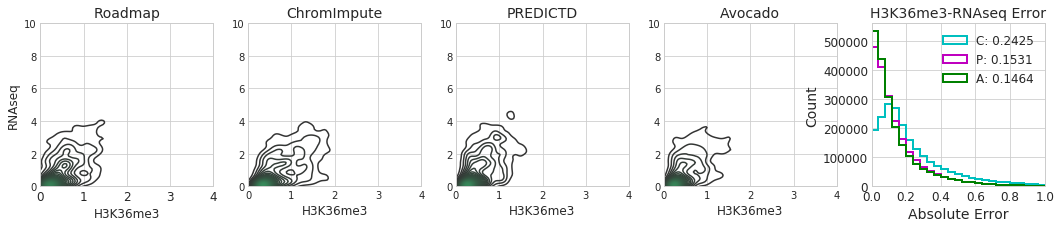

In [30]:
plot_errors(H3K36me3_1, RNAseq, H3K36me3_2, RNAseq, H3K36me3_3, RNAseq, H3K36me3_4, RNAseq, "H3K36me3", "RNAseq", 4, 10, 1)
plt.savefig("Avocado-Supplement_H3K36me3_RNAseq.pdf")

## 2.9.1: Association Between H3K4me3 and H3K27me3

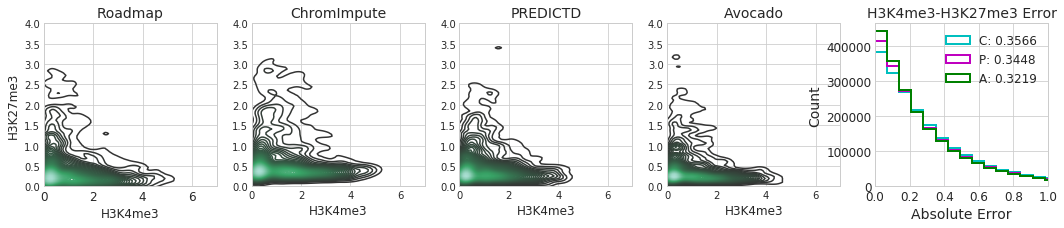

In [32]:
H3K4me3_1 = data['H3K4me3_Roadmap'].values
H3K4me3_2 = data['H3K4me3_ChromImpute'].values
H3K4me3_3 = data['H3K4me3_PREDICTD'].values
H3K4me3_4 = data['H3K4me3_Avocado'].values

H3K27me3_1 = data['H3K27me3_Roadmap'].values
H3K27me3_2 = data['H3K27me3_ChromImpute'].values
H3K27me3_3 = data['H3K27me3_PREDICTD'].values
H3K27me3_4 = data['H3K27me3_Avocado'].values

plot_errors(H3K4me3_1, H3K27me3_1, H3K4me3_2, H3K27me3_2, H3K4me3_3, H3K27me3_3, H3K4me3_4, H3K27me3_4, "H3K4me3", "H3K27me3", 7, 4, 1)
plt.savefig("Avocado-Supplement_H3K4me3_H3K27me3.pdf")

In [37]:
H3K27me3_1.shape

(2123948,)

## Association Between H3K4me3 and H3K36me3 

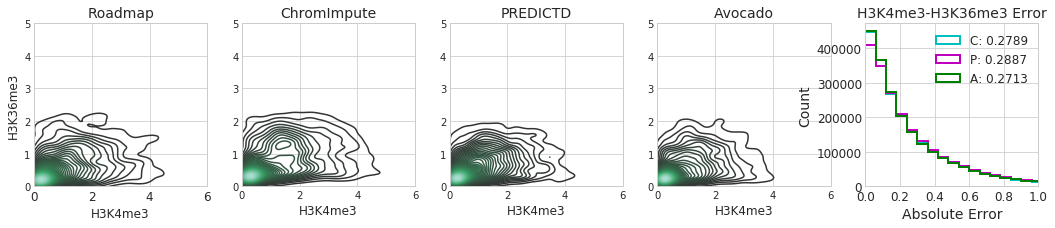

In [33]:
plot_errors(H3K4me3_1, H3K36me3_1, H3K4me3_2, H3K36me3_2, H3K4me3_3, H3K36me3_3, H3K4me3_4, H3K36me3_4, "H3K4me3", "H3K36me3", 6, 5, 1)
plt.savefig("Avocado-Supplement_H3K4me3_H3K36me3.pdf")

## 2.9.3: Association Between H3K27me3 and H3K36me3

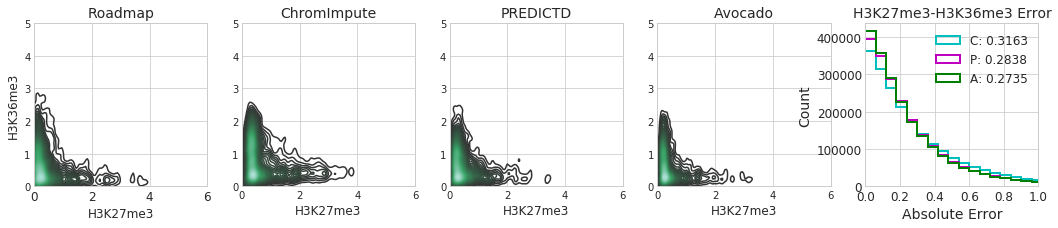

In [34]:
plot_errors(H3K27me3_1, H3K36me3_1, H3K27me3_2, H3K36me3_2, H3K27me3_3, H3K36me3_3, H3K27me3_4, H3K36me3_4, "H3K27me3", "H3K36me3", 6, 5, 1)
plt.savefig("Avocado-Supplement_H3K27me3_H3K36me3.pdf")

## 2.9.4 Association Between H3K27me3 and H3K4me1

In [35]:
H3K4me1_1 = data['H3K4me1_Roadmap'].values
H3K4me1_2 = data['H3K4me1_ChromImpute'].values
H3K4me1_3 = data['H3K4me1_PREDICTD'].values
H3K4me1_4 = data['H3K4me1_Avocado'].values

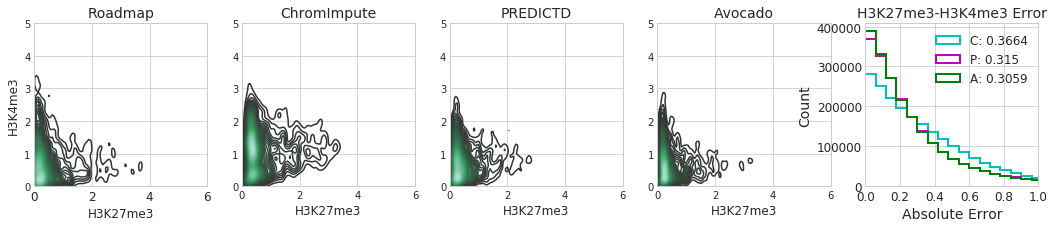

In [36]:
plot_errors(H3K27me3_1, H3K4me1_1, H3K27me3_2, H3K4me1_2, H3K27me3_3, H3K4me1_3, H3K27me3_4, H3K4me1_4, "H3K27me3", "H3K4me3", 6, 5, 1)
plt.savefig("Avocado-Supplement_H3K27me3_H3K4me1.pdf")

## 2.9.4 Identification of Bivalent Promoters

In [72]:
corr_1 = data['Roadmap_corr'].values
corr_2 = data['ChromImpute_corr'].values
corr_3 = data['PREDICTD_corr'].values
corr_4 = data['Avocado_corr'].values

idx = (~numpy.isnan(corr_1)) & (~numpy.isnan(corr_2)) & (~numpy.isnan(corr_3)) & (~numpy.isnan(corr_4))

x1 = corr_1[idx] * numpy.min([H3K4me3_1[idx], H3K27me3_1[idx]], axis=0)
x2 = corr_2[idx] * numpy.min([H3K4me3_2[idx], H3K27me3_2[idx]], axis=0)
x3 = corr_3[idx] * numpy.min([H3K4me3_3[idx], H3K27me3_3[idx]], axis=0)
x4 = corr_4[idx] * numpy.min([H3K4me3_4[idx], H3K27me3_4[idx]], axis=0)

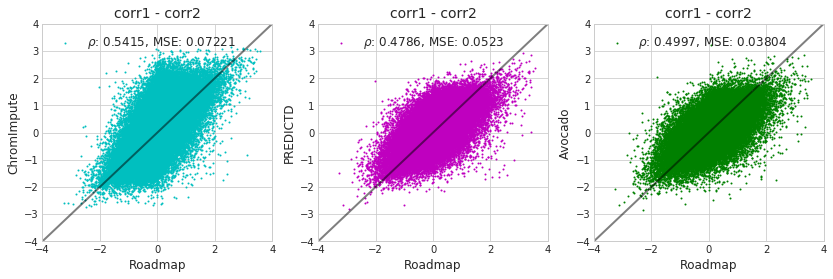

In [15]:
plot_pairs(x1, x2, x3, x4, "corr1", "corr2", (-4, 4), (-4, 4))

Text(0.5,1,u'Absolute Error in Bivalency Relationship')

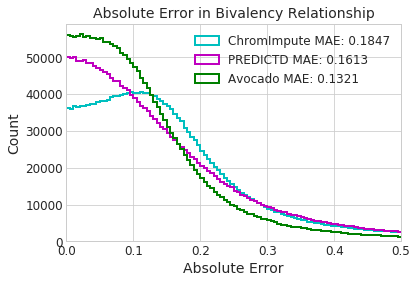

In [14]:
plot_histograms(x1, x2, x3, x4, "Bivalency", "corr2", 0.5)
plt.title("Absolute Error in Bivalency Relationship", fontsize=14)

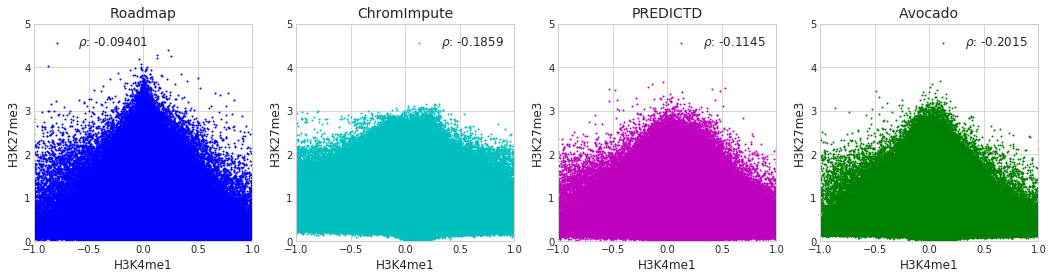

In [24]:
plot_methods(x1, H3K36me3_1[idx], x2, H3K36me3_2[idx], x3, H3K36me3_3[idx], x4, H3K36me3_4[idx], 
             "H3K4me1", "H3K27me3", (-1, 1), (0, 5))

In [103]:
x1 = corr_1[idx] * numpy.min([H3K4me3_1[idx], H3K27me3_1[idx]], axis=0) * H3K36me3_1[idx]
x2 = corr_2[idx] * numpy.min([H3K4me3_2[idx], H3K27me3_2[idx]], axis=0) * H3K36me3_2[idx]
x3 = corr_3[idx] * numpy.min([H3K4me3_3[idx], H3K27me3_3[idx]], axis=0) * H3K36me3_3[idx]
x4 = corr_4[idx] * numpy.min([H3K4me3_4[idx], H3K27me3_4[idx]], axis=0) * H3K36me3_4[idx]

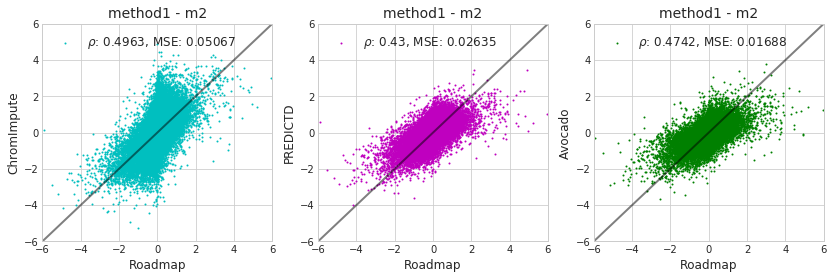

In [104]:
plot_pairs(x1, x2, x3, x4, "method1", "m2", (-6, 6), (-6, 6))

Text(0.5,1,u'Absolute Error in Bivalency * H3K36me3 Relationship')

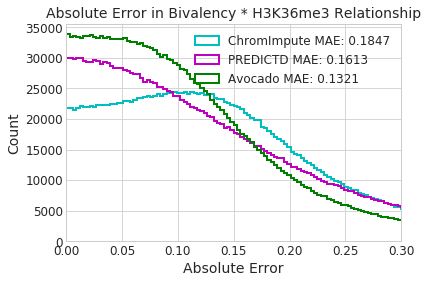

In [16]:
plot_histograms(x1, x2, x3, x4, "method1", "m2", 0.3) 
plt.title("Absolute Error in Bivalency * H3K36me3 Relationship", fontsize=14)